In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df_labeled= pd.read_csv('/content/drive/My Drive/Master_Thesis/new_labeled_dataset.csv')
df_labeled


,generated_summary,labels
0,i understand that when someone immediately off...,2
1,i'm here to welcome you to the r/depression ch...,1
2,i stay up all night when i'm depressed to dela...,2
3,"i have procrastinated a lot in my life, avoidi...",2
4,i find that sleep is my ultimate escape and so...,1
...,...,...
7726,i see snow.,0
7727,i watched moulin rouge and it made me cry once...,0
7728,"i am attempting to call out, but i am unable t...",0
7729,"i can't find my red sox hat, so i have to wear...",0


In [ ]:
df_labeled.isnull().sum()

generated_summary    0
labels               0
dtype: int64

In [ ]:
X = df_labeled['generated_summary']
y = df_labeled['labels']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
y_train.value_counts(),y_test.value_counts()

(labels
 0    3119
 2    1169
 1    1061
 3     835
 Name: count, dtype: int64,
 labels
 0    781
 2    292
 1    265
 3    209
 Name: count, dtype: int64)

In [ ]:
X_train.nunique()

6170

In [ ]:
y_test.value_counts()

labels
0    780
2    279
1    252
3    236
Name: count, dtype: int64

In [ ]:
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import RandomizedSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

X = df_labeled['generated_summary']
y = df_labeled['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return lemmas

def preprocessing(text):
    lower_text = text.lower()
    punctuation_free = "".join([chars for chars in lower_text if chars not in string.punctuation])
    remove_urls = re.sub(r'http\S+', '', punctuation_free)
    remove_digits = re.sub(r'\d', '', remove_urls)
    tokenized_text = word_tokenize(remove_digits)

    # Remove stop words
    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return lemmatized_tokens

preprocess_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=preprocessing,
        stop_words='english'
    ))
])

tfidf_param_dist = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
}

tfidf_random_search = RandomizedSearchCV(preprocess_pipeline, param_distributions=tfidf_param_dist, n_iter=10, cv=5, scoring='f1_weighted', random_state=42)
tfidf_random_search.fit(X_train, y_train)

best_tfidf_params = tfidf_random_search.best_params_


best_tfidf_vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words='english',
    **{param.replace('tfidf__', ''): value for param, value in best_tfidf_params.items()}  # Additional best parameters
)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'train_test_split' is not defined

In [ ]:
print(best_tfidf_params)

{'tfidf__ngram_range': (1, 1)}


In [ ]:
import joblib
joblib.dump(best_tfidf_vectorizer,'/content/drive/My Drive/Master_Thesis/best_tfidf_vectorizer.pkl')

NameError: name 'best_tfidf_vectorizer' is not defined

In [ ]:

joblib.dump(X_train,'/content/drive/My Drive/Master_Thesis/X_train.pkl')
joblib.dump(y_train,'/content/drive/My Drive/Master_Thesis/y_train.pkl')
joblib.dump(X_test,'/content/drive/My Drive/Master_Thesis/X_test.pkl')
joblib.dump(y_test,'/content/drive/My Drive/Master_Thesis/y_test.pkl')


**XGBOOST PART**

In [ ]:
!pip install xgboost==1.4.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3


In [ ]:
import joblib

import joblib
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    # Convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return lemmas

def preprocessing(text):
    lower_text = text.lower()
    punctuation_free = "".join([chars for chars in lower_text if chars not in string.punctuation])
    remove_urls = re.sub(r'http\S+', '', punctuation_free)
    remove_digits = re.sub(r'\d', '', remove_urls)
    tokenized_text = word_tokenize(remove_digits)

    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return lemmatized_tokens

best_tfidf_vectorizer = joblib.load('/content/drive/My Drive/Master_Thesis/best_tfidf_vectorizer.pkl')

In [ ]:
X_train=joblib.load('/content/drive/My Drive/Master_Thesis/X_train.pkl')
y_train=joblib.load('/content/drive/My Drive/Master_Thesis/y_train.pkl')
X_test=joblib.load('/content/drive/My Drive/Master_Thesis/X_test.pkl')
y_test=joblib.load('/content/drive/My Drive/Master_Thesis/y_test.pkl')


In [ ]:
# Fit TF-IDF vectorizer with training data and transform both training and testing data


import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import RandomizedSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

X_train_tfidf = best_tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = best_tfidf_vectorizer.transform(X_test)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make', 'u'] not in stop_words.
  warnings.warn(


In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print('GPU is available!')
    print('CUDA device:', torch.cuda.get_device_name(0))
else:
    print('GPU is not available. Using CPU...')

GPU is available!
CUDA device: Tesla T4


upper bound

In [ ]:
from xgboost import XGBClassifier
#not all the parameter may affect only some parameter have effect on the model

In [ ]:
#trying to print the default values

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()

default_params = model.get_params()
for key, value in default_params.items():
    print(f"{key}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: None
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: None
n_jobs: None
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: None


X_train_tfidf shape: (6184, 9056), y_train shape: 6184
Sample weights length: 6184
Best F1 Score: 0.818192 using {'n_estimators': 200}
n_estimators: 0, Mean F1 Score: 0.338376 (Std: 0.000182), Mean Log Loss: 1.386294 (Std: 0.000000)
n_estimators: 50, Mean F1 Score: 0.809839 (Std: 0.005122), Mean Log Loss: 0.503692 (Std: 0.007161)
n_estimators: 100, Mean F1 Score: 0.817848 (Std: 0.004507), Mean Log Loss: 0.478182 (Std: 0.006938)
n_estimators: 150, Mean F1 Score: 0.817719 (Std: 0.005020), Mean Log Loss: 0.477744 (Std: 0.007039)
n_estimators: 200, Mean F1 Score: 0.818192 (Std: 0.004246), Mean Log Loss: 0.486232 (Std: 0.005934)
n_estimators: 250, Mean F1 Score: 0.817329 (Std: 0.003318), Mean Log Loss: 0.498222 (Std: 0.006935)
n_estimators: 300, Mean F1 Score: 0.815926 (Std: 0.000834), Mean Log Loss: 0.512508 (Std: 0.008980)
n_estimators: 350, Mean F1 Score: 0.814579 (Std: 0.001248), Mean Log Loss: 0.529456 (Std: 0.010218)
Best Log Loss: 0.477744 using {'n_estimators': 150}


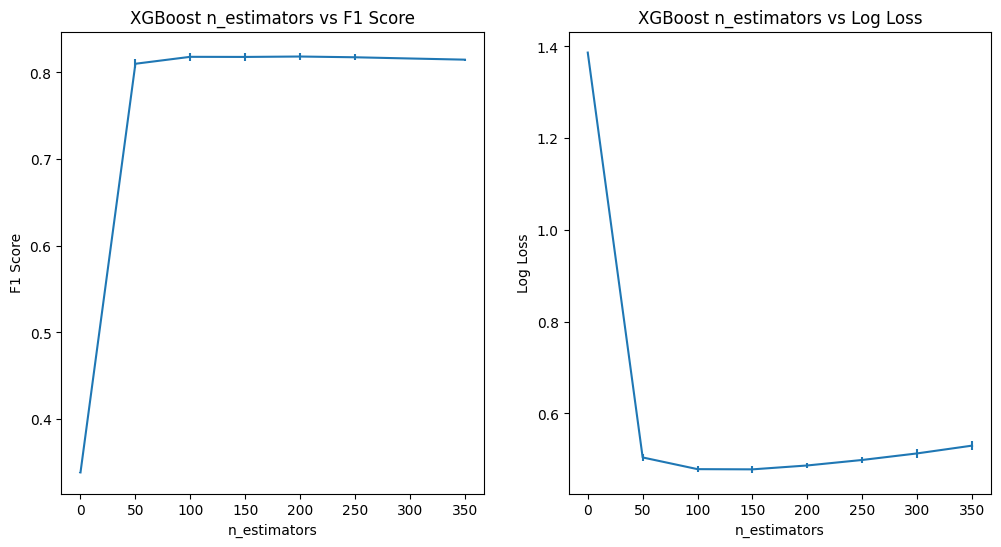

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, log_loss, f1_score
from matplotlib import pyplot as plt

print(f"X_train_tfidf shape: {X_train_tfidf.shape}, y_train shape: {len(y_train)}")

# Compute sample weights for imbalanced classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Verify the length of sample_weights matches y_train
print(f"Sample weights length: {len(sample_weights)}")

n_estimators = range(0, 400, 50)
param_grid = dict(n_estimators=n_estimators)

xgb_classifier = XGBClassifier(objective='multi:softprob')

log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

xgb_grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=5,
    scoring={'f1_weighted': 'f1_weighted', 'neg_log_loss': log_loss_scorer},
    refit='f1_weighted',
    return_train_score=True
)

# Fit the XGBoost classifier with training data and sample weights
xgb_grid_search.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

# Print the best F1 score and best parameters
print("Best F1 Score: %f using %s" % (xgb_grid_search.best_score_, xgb_grid_search.best_params_))

# Extract the results
results = xgb_grid_search.cv_results_
means_f1 = results['mean_test_f1_weighted']
stds_f1 = results['std_test_f1_weighted']
means_log_loss = -results['mean_test_neg_log_loss']
stds_log_loss = results['std_test_neg_log_loss']
params = results['params']

# Initialize variables to keep track of the best log loss and its corresponding parameters
best_log_loss = float('inf')
best_log_loss_params = None

# Prepare data for CSV
data = []
for mean_f1, std_f1, mean_log_loss, std_log_loss, param in zip(means_f1, stds_f1, means_log_loss, stds_log_loss, params):
    data.append({
        'n_estimators': param['n_estimators'],
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'mean_log_loss': mean_log_loss,
        'std_log_loss': std_log_loss
    })
    print("n_estimators: %d, Mean F1 Score: %f (Std: %f), Mean Log Loss: %f (Std: %f)" %
          (param['n_estimators'], mean_f1, std_f1, mean_log_loss, std_log_loss))

    # Check if the current log loss is better than the best log loss so far
    if mean_log_loss < best_log_loss:
        best_log_loss = mean_log_loss
        best_log_loss_params = param

# Print the best log loss and its corresponding parameters
print("Best Log Loss: %f using %s" % (best_log_loss, best_log_loss_params))

# Convert data to a DataFrame and save to CSV
df = pd.DataFrame(data)
df.to_csv('xgboost_results_estimator_from0to400.csv', index=False)  # <--- This is the part that stores the results in a CSV file

# Plot the results for F1 score
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.errorbar(n_estimators, means_f1, yerr=stds_f1)
plt.title("XGBoost n_estimators vs F1 Score")
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')

# Plot the results for Log Loss
plt.subplot(1, 2, 2)
plt.errorbar(n_estimators, means_log_loss, yerr=stds_log_loss)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

# Save the figure
plt.savefig('n_estimators.png')
plt.show()

X_train_tfidf shape: (6184, 9056), y_train shape: 6184
Sample weights length: 6184
Best F1 Score: 0.819761 using {'n_estimators': 190}
n_estimators: 0, Mean F1 Score: 0.338376 (Std: 0.000182), Mean Log Loss: 1.386294 (Std: 0.000000)
n_estimators: 10, Mean F1 Score: 0.780361 (Std: 0.005892), Mean Log Loss: 0.675769 (Std: 0.010186)
n_estimators: 20, Mean F1 Score: 0.800198 (Std: 0.004556), Mean Log Loss: 0.577899 (Std: 0.009895)
n_estimators: 30, Mean F1 Score: 0.805640 (Std: 0.006288), Mean Log Loss: 0.538182 (Std: 0.008313)
n_estimators: 40, Mean F1 Score: 0.809837 (Std: 0.004584), Mean Log Loss: 0.515982 (Std: 0.007569)
n_estimators: 50, Mean F1 Score: 0.809839 (Std: 0.005122), Mean Log Loss: 0.503692 (Std: 0.007161)
n_estimators: 60, Mean F1 Score: 0.812123 (Std: 0.004500), Mean Log Loss: 0.494065 (Std: 0.005679)
n_estimators: 70, Mean F1 Score: 0.813636 (Std: 0.006250), Mean Log Loss: 0.489154 (Std: 0.006417)
n_estimators: 80, Mean F1 Score: 0.814401 (Std: 0.006069), Mean Log Loss: 

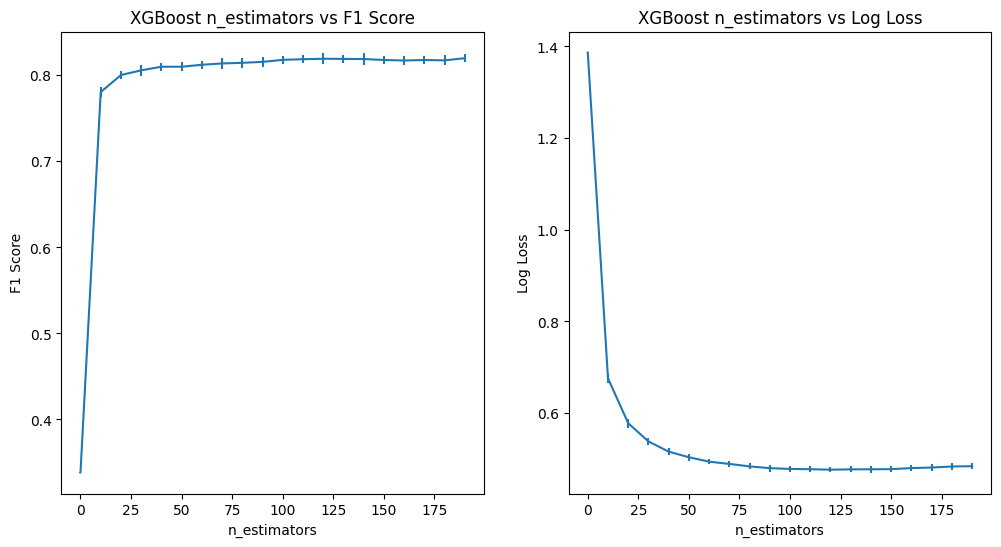

In [ ]:
# nestimator 0 to 200

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, log_loss, f1_score
from matplotlib import pyplot as plt


print(f"X_train_tfidf shape: {X_train_tfidf.shape}, y_train shape: {len(y_train)}")

# Compute sample weights for imbalanced classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Verify the length of sample_weights matches y_train
print(f"Sample weights length: {len(sample_weights)}")

# Define parameter grid for XGBoost
n_estimators = range(0, 200, 10)
param_grid = dict(n_estimators=n_estimators)

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(objective='multi:softprob')

# Define a custom scorer for log loss
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Perform Grid Search CV with both F1 and log loss scoring
xgb_grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=5,
    scoring={'f1_weighted': 'f1_weighted', 'neg_log_loss': log_loss_scorer},
    refit='f1_weighted',
    return_train_score=True
)

xgb_grid_search.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

print("Best F1 Score: %f using %s" % (xgb_grid_search.best_score_, xgb_grid_search.best_params_))

results = xgb_grid_search.cv_results_
means_f1 = results['mean_test_f1_weighted']
stds_f1 = results['std_test_f1_weighted']
means_log_loss = -results['mean_test_neg_log_loss']
stds_log_loss = results['std_test_neg_log_loss']
params = results['params']

# Initialize variables to keep track of the best log loss and its corresponding parameters
best_log_loss = float('inf')
best_log_loss_params = None

# Prepare data for CSV
data = []
for mean_f1, std_f1, mean_log_loss, std_log_loss, param in zip(means_f1, stds_f1, means_log_loss, stds_log_loss, params):
    data.append({
        'n_estimators': param['n_estimators'],
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'mean_log_loss': mean_log_loss,
        'std_log_loss': std_log_loss
    })
    print("n_estimators: %d, Mean F1 Score: %f (Std: %f), Mean Log Loss: %f (Std: %f)" %
          (param['n_estimators'], mean_f1, std_f1, mean_log_loss, std_log_loss))

    # Check if the current log loss is better than the best log loss so far
    if mean_log_loss < best_log_loss:
        best_log_loss = mean_log_loss
        best_log_loss_params = param

print("Best Log Loss: %f using %s" % (best_log_loss, best_log_loss_params))

df = pd.DataFrame(data)
df.to_csv('xgboost_results_estimator_from0to400.csv', index=False)  # <--- This is the part that stores the results in a CSV file

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.errorbar(n_estimators, means_f1, yerr=stds_f1)
plt.title("XGBoost n_estimators vs F1 Score")
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')

plt.subplot(1, 2, 2)
plt.errorbar(n_estimators, means_log_loss, yerr=stds_log_loss)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

plt.savefig('n_estimators.png')
plt.show()

[0]	validation_0-mlogloss:1.14708	validation_1-mlogloss:1.16301
[1]	validation_0-mlogloss:0.99186	validation_1-mlogloss:1.02564
[2]	validation_0-mlogloss:0.88301	validation_1-mlogloss:0.93001
[3]	validation_0-mlogloss:0.80426	validation_1-mlogloss:0.86191
[4]	validation_0-mlogloss:0.74147	validation_1-mlogloss:0.81137
[5]	validation_0-mlogloss:0.69568	validation_1-mlogloss:0.77112
[6]	validation_0-mlogloss:0.66002	validation_1-mlogloss:0.74281
[7]	validation_0-mlogloss:0.62965	validation_1-mlogloss:0.71710
[8]	validation_0-mlogloss:0.60202	validation_1-mlogloss:0.69805
[9]	validation_0-mlogloss:0.57744	validation_1-mlogloss:0.67905
[10]	validation_0-mlogloss:0.55401	validation_1-mlogloss:0.66437
[11]	validation_0-mlogloss:0.53667	validation_1-mlogloss:0.64966
[12]	validation_0-mlogloss:0.51965	validation_1-mlogloss:0.63360
[13]	validation_0-mlogloss:0.50500	validation_1-mlogloss:0.62468
[14]	validation_0-mlogloss:0.49164	validation_1-mlogloss:0.61423
[15]	validation_0-mlogloss:0.48028	

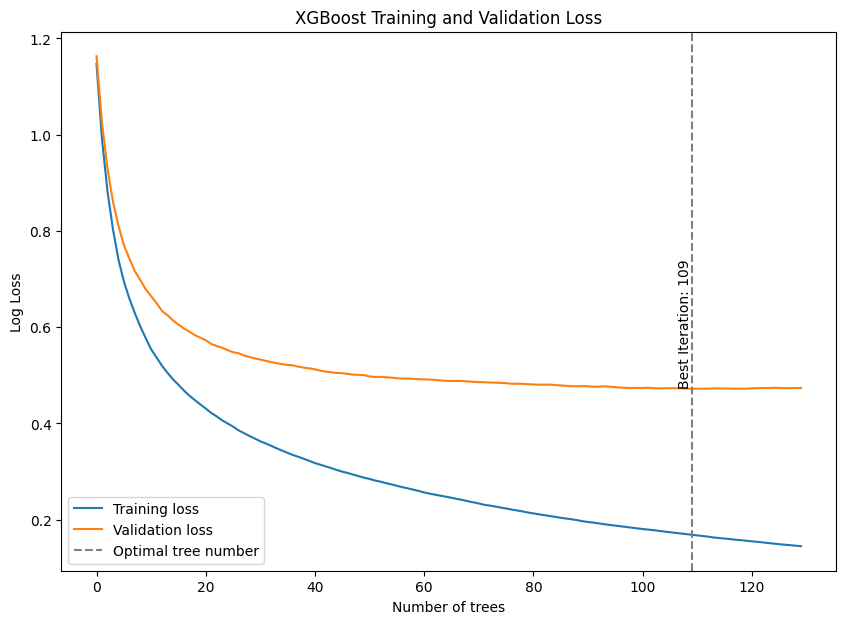

Optimal number of estimators: 109


In [ ]:
#this result with the default max depth =3
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd



X_train, X_validation, y_train, y_validation = train_test_split(X_train_tfidf,
                                                                y_train, test_size=0.2, random_state=42)

# Compute sample weights for imbalanced classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=200,
                               learning_rate=0.3,
                               early_stopping_rounds=20, eval_metric='mlogloss')

# Fit the XGBoost classifier with early stopping based on log loss
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_validation, y_validation)],
                   sample_weight=sample_weights, verbose=True)

results = xgb_classifier.evals_result()

# Extract log loss values
train_log_loss = results['validation_0']['mlogloss']
validation_log_loss = results['validation_1']['mlogloss']

evaluation_results = pd.DataFrame({
    'train_log_loss': train_log_loss,
    'validation_log_loss': validation_log_loss
})
evaluation_results.to_csv('xgboost_estimator_with_early_stopping_evaluation_results.csv', index_label='n_estimators')

# Plot the training and validation loss
plt.figure(figsize=(10, 7))
plt.plot(train_log_loss, label="Training loss")
plt.plot(validation_log_loss, label="Validation loss")
optimal_num_estimators = np.argmin(validation_log_loss)
plt.axvline(x=optimal_num_estimators, color="gray", linestyle="--", label="Optimal tree number")
plt.text(optimal_num_estimators, min(validation_log_loss), f'Best Iteration: {optimal_num_estimators}', rotation=90, va='bottom', ha='right')
plt.xlabel("Number of trees")
plt.ylabel("Log Loss")
plt.title("XGBoost Training and Validation Loss")
plt.legend()
plt.savefig('xgboost_the_best_estimator.png')
plt.show()

print("Optimal number of estimators:", optimal_num_estimators)

Final Training F1 Score Mean: 0.9880
Final Validation F1 Score Mean: 0.8204


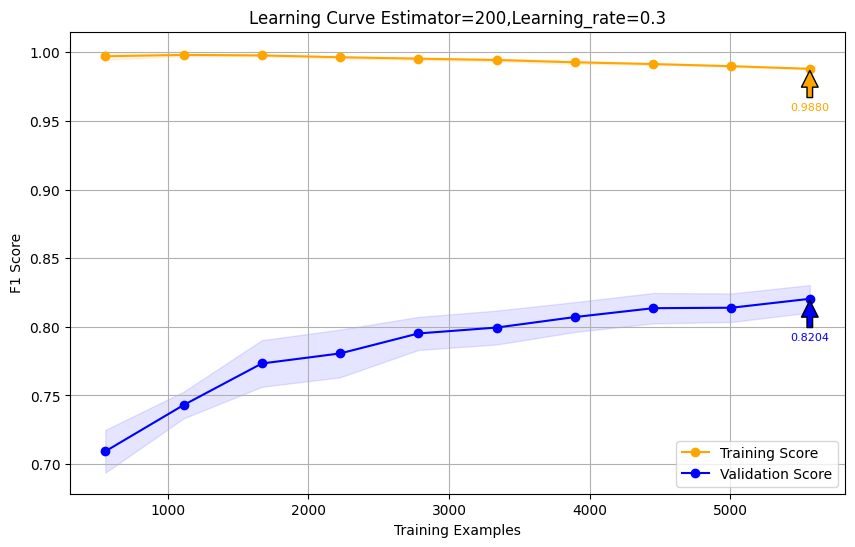

In [ ]:

from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

# Define the XGBoost classifier with hyperparameters
xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=200,
                               learning_rate=0.3)

# Plot learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_classifier, X_train_tfidf, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Print final F1 scores for training and validation
final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

print(f"Final Training F1 Score Mean: {final_train_f1_mean:.4f}")
print(f"Final Validation F1 Score Mean: {final_valid_f1_mean:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Learning Curve Estimator=200,Learning_rate=0.3')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="orange", alpha=0.1)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, color="blue", alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")

# Add annotations for the final F1 scores
plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean- 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean- 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
plt.savefig('learning_curve_XGBoost(n_estimators=200).png')  # Save the plot with filename based on class number

plt.show()

Final Training F1 Score Mean: 0.9618
Final Validation F1 Score Mean: 0.8139


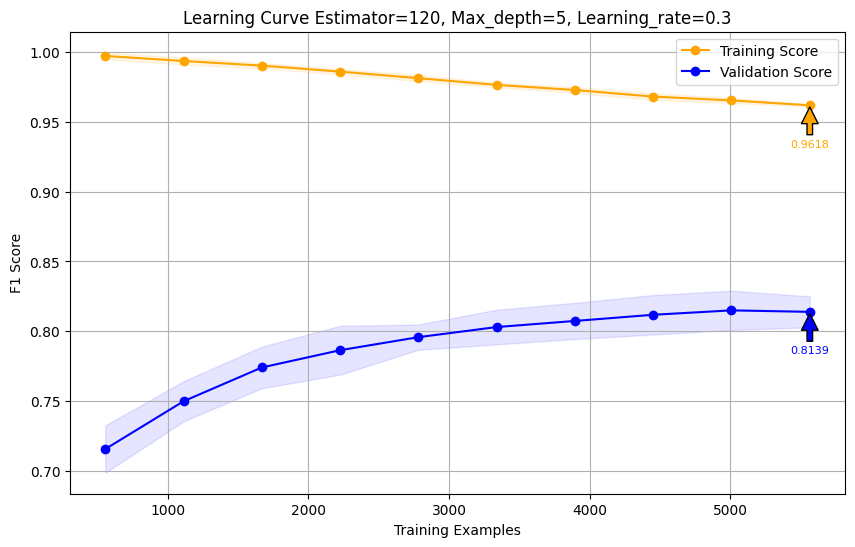

In [ ]:

from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

# Define the XGBoost classifier with hyperparameters
xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=120,
                               max_depth=5, learning_rate=0.3)

# Plot learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_classifier, X_train_tfidf, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Print final F1 scores for training and validation
final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

print(f"Final Training F1 Score Mean: {final_train_f1_mean:.4f}")
print(f"Final Validation F1 Score Mean: {final_valid_f1_mean:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Learning Curve Estimator=120, Max_depth=5, Learning_rate=0.3')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="orange", alpha=0.1)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, color="blue", alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")

# Add annotations for the final F1 scores
plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean - 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean - 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
plt.savefig('learning_curve_XGBoost(n_estimators=120,max_depth=5,learning_rate=0.3).png')  # Save the plot with filename based on class number

plt.show()

Final Training F1 Score Mean: 0.9690
Final Validation F1 Score Mean: 0.8161


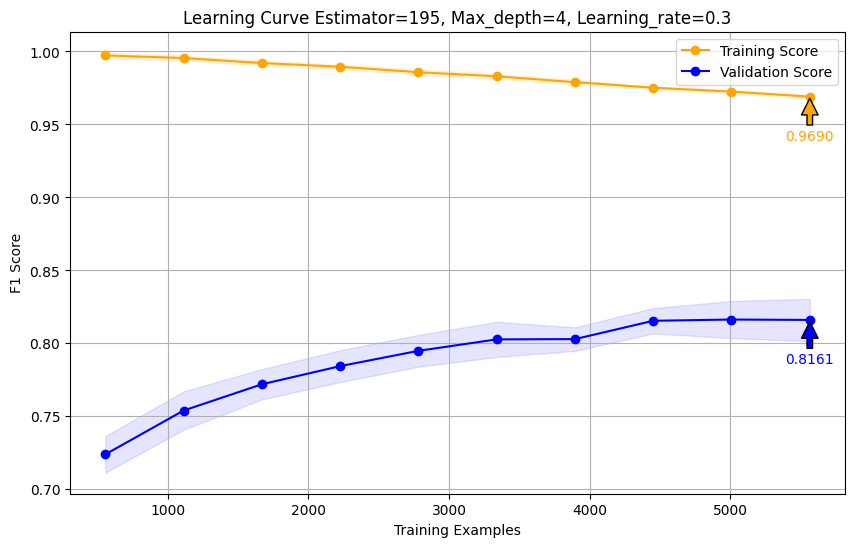

In [ ]:
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=195,
                               max_depth=4, learning_rate=0.3)

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_classifier, X_train_tfidf, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Print final F1 scores for training and validation
final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

print(f"Final Training F1 Score Mean: {final_train_f1_mean:.4f}")
print(f"Final Validation F1 Score Mean: {final_valid_f1_mean:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Learning Curve Estimator=195, Max_depth=4, Learning_rate=0.3')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="orange", alpha=0.1)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, color="blue", alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")

plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean- 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=10, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean- 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=10, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
plt.savefig('learning_curve_XGBoost(n_estimators=195,max_depth=4,learning_rate=0.3).png')  # Save the plot with filename based on class number

plt.show()

In [ ]:
#adding learning rate
#Learning Rate: 0.23, Mean F1 Score: 0.816546 (Std: 0.004440), Mean Log Loss: 0.482689 (Std: 0.007709)
#Learning Rate: 0.16, Mean F1 Score: 0.816109 (Std: 0.005155), Mean Log Loss: 0.497181 (Std: 0.005885)


Final Training F1 Score Mean: 0.9311
Final Validation F1 Score Mean: 0.8131


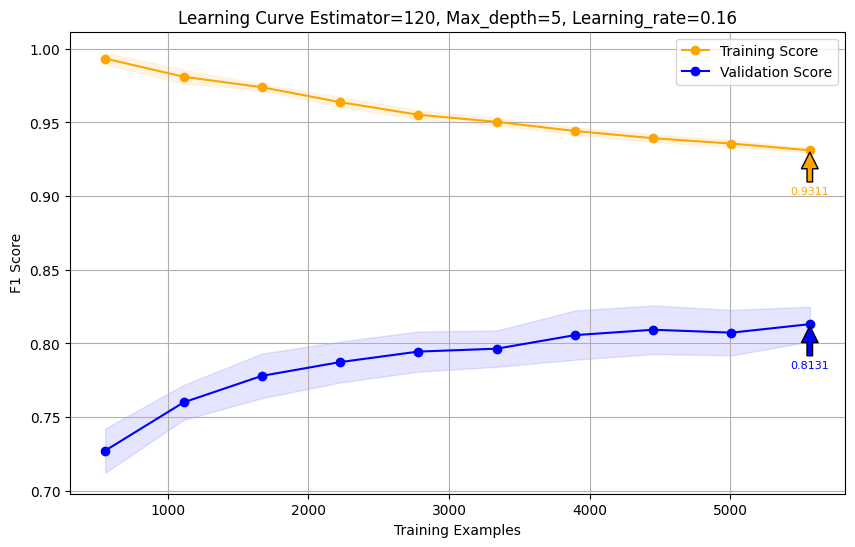

In [ ]:
#learningrate =0.16 estiumator=120, maxdepth=5

from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=120,
                               max_depth=5, learning_rate=0.16)

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_classifier, X_train_tfidf, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Print final F1 scores for training and validation
final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

print(f"Final Training F1 Score Mean: {final_train_f1_mean:.4f}")
print(f"Final Validation F1 Score Mean: {final_valid_f1_mean:.4f}")

plt.figure(figsize=(10, 6))
plt.title('Learning Curve Estimator=120, Max_depth=5, Learning_rate=0.16')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="orange", alpha=0.1)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, color="blue", alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")

# Add annotations for the final F1 scores
plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean - 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean - 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
plt.savefig('learning_curve_XGBoost(n_estimators=120,max_depth=5,learning_rate=0.16).png')  # Save the plot with filename based on class number

plt.show()

Final Training F1 Score Mean: 0.9494
Final Validation F1 Score Mean: 0.8158


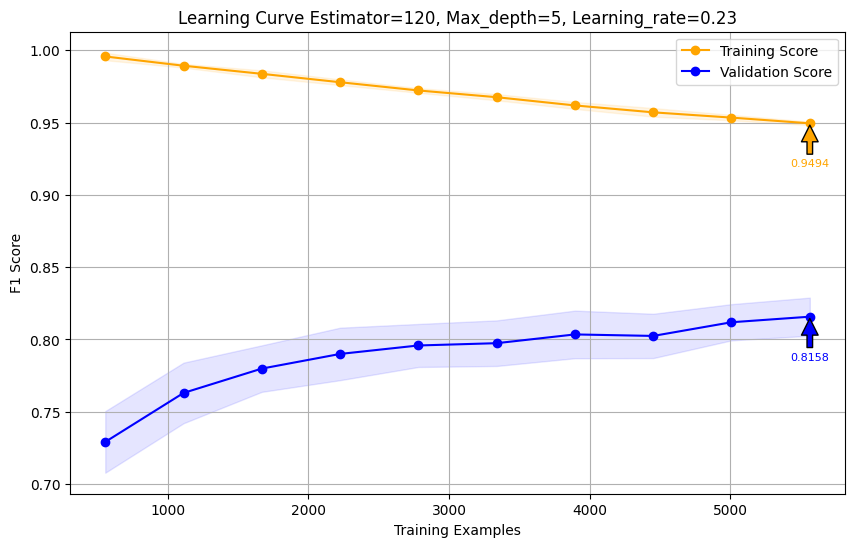

In [ ]:
#learningrate =0.16 estiumator=120, maxdepth=5

from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=120,
                               max_depth=5, learning_rate=0.23)

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_classifier, X_train_tfidf, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

print(f"Final Training F1 Score Mean: {final_train_f1_mean:.4f}")
print(f"Final Validation F1 Score Mean: {final_valid_f1_mean:.4f}")

plt.figure(figsize=(10, 6))
plt.title('Learning Curve Estimator=120, Max_depth=5, Learning_rate=0.23')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="orange", alpha=0.1)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, color="blue", alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")

plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean - 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean - 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
plt.savefig('learning_curve_XGBoost(n_estimators=120,max_depth=5,learning_rate=0.23).png')  # Save the plot with filename based on class number

plt.show()

Final Training F1 Score Mean: 0.9559
Final Validation F1 Score Mean: 0.8194


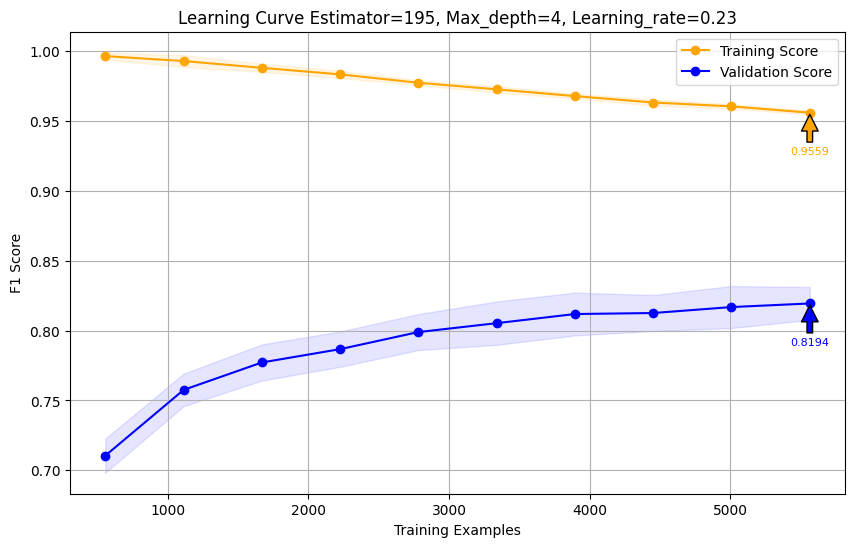

In [ ]:
#learningrate =0.16 estiumator=120, maxdepth=5

from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=195,
                               max_depth=4, learning_rate=0.23)

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_classifier, X_train_tfidf, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

print(f"Final Training F1 Score Mean: {final_train_f1_mean:.4f}")
print(f"Final Validation F1 Score Mean: {final_valid_f1_mean:.4f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Learning Curve Estimator=195, Max_depth=4, Learning_rate=0.23')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="orange", alpha=0.1)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, color="blue", alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")

# Add annotations for the final F1 scores
plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean - 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean - 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
plt.savefig('learning_curve_XGBoost(n_estimators=195,max_depth=4,learning_rate=0.23).png')  # Save the plot with filename based on class number

plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:56:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:57:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:58:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:59:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:00:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:02:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:04:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:04:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:04:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:04:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 Score: 0.815808 using {'max_depth': 3}
max_depth: 1, Mean F1 Score: 0.787500 (Std: 0.007395), Mean Log Loss: 0.630685 (Std: 0.007642)
max_depth: 3, Mean F1 Score: 0.815808 (Std: 0.005851), Mean Log Loss: 0.505063 (Std: 0.006982)
max_depth: 5, Mean F1 Score: 0.815175 (Std: 0.006925), Mean Log Loss: 0.481296 (Std: 0.008772)
max_depth: 7, Mean F1 Score: 0.813029 (Std: 0.003122), Mean Log Loss: 0.479183 (Std: 0.007348)
max_depth: 9, Mean F1 Score: 0.813210 (Std: 0.005092), Mean Log Loss: 0.487887 (Std: 0.007048)
max_depth: 11, Mean F1 Score: 0.808597 (Std: 0.002879), Mean Log Loss: 0.501749 (Std: 0.010750)
max_depth: 13, Mean F1 Score: 0.805193 (Std: 0.004822), Mean Log Loss: 0.521307 (Std: 0.013842)
max_depth: 15, Mean F1 Score: 0.8

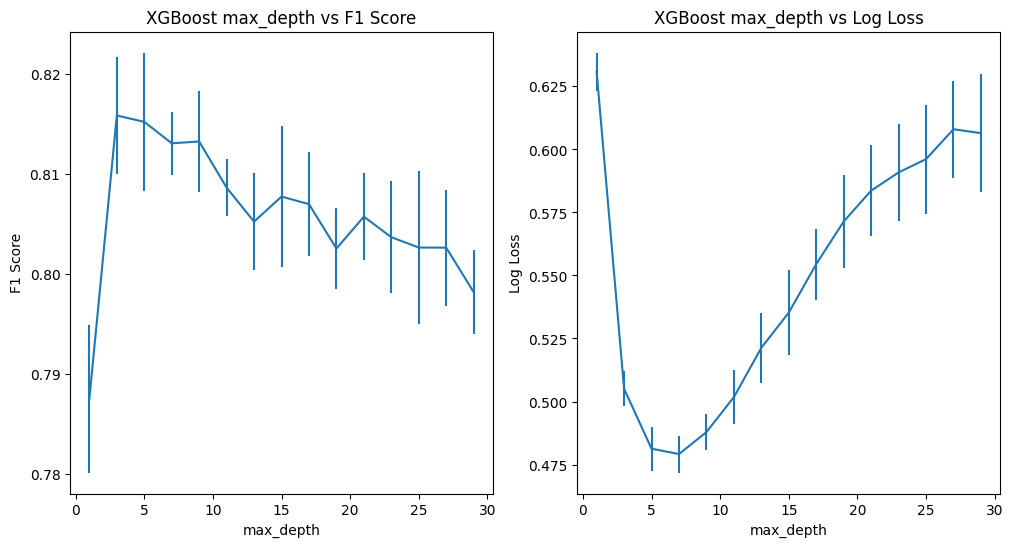

In [ ]:
#####tune max depth with default
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, log_loss, f1_score
from matplotlib import pyplot as plt
# Compute sample weights for imbalanced classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
max_depths = range(1, 30,2)
param_grid = dict(max_depth=max_depths)

xgb_classifier = XGBClassifier(objective='multi:softprob')

xgb_grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=5,
    scoring={'f1_weighted': 'f1_weighted', 'neg_log_loss': log_loss_scorer},
    refit='f1_weighted',
    return_train_score=True
)

xgb_grid_search.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

# Print the best F1 score and best parameters
print("Best F1 Score: %f using %s" % (xgb_grid_search.best_score_, xgb_grid_search.best_params_))

results = xgb_grid_search.cv_results_
means_f1 = results['mean_test_f1_weighted']
stds_f1 = results['std_test_f1_weighted']
means_log_loss = -results['mean_test_neg_log_loss']
stds_log_loss = results['std_test_neg_log_loss']
params = results['params']

# Initialize variables to keep track of the best log loss and its corresponding parameters
best_log_loss = float('inf')
best_log_loss_params = None

# Print the F1 score and log loss for each max_depth
for mean_f1, std_f1, mean_log_loss, std_log_loss, param in zip(means_f1, stds_f1, means_log_loss, stds_log_loss, params):
    print("max_depth: %d, Mean F1 Score: %f (Std: %f), Mean Log Loss: %f (Std: %f)" %
          (param['max_depth'], mean_f1, std_f1, mean_log_loss, std_log_loss))

    # Check if the current log loss is better than the best log loss so far
    if mean_log_loss < best_log_loss:
        best_log_loss = mean_log_loss
        best_log_loss_params = param

# Print the best log loss and its corresponding parameters
print("Best Log Loss: %f using %s" % (best_log_loss, best_log_loss_params))

# Plot the results for F1 score
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.errorbar(max_depths, means_f1, yerr=stds_f1)
plt.title("XGBoost max_depth vs F1 Score")
plt.xlabel('max_depth')
plt.ylabel('F1 Score')

# Plot the results for Log Loss
plt.subplot(1, 2, 2)
plt.errorbar(max_depths, means_log_loss, yerr=stds_log_loss)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')

plt.savefig('max_depth.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

Best F1 Score: 0.815719 using {'max_depth': 5}
max_depth: 1, Mean F1 Score: 0.809651 (Std: 0.007614), Mean Log Loss: 0.547344 (Std: 0.006793)
max_depth: 3, Mean F1 Score: 0.813604 (Std: 0.003862), Mean Log Loss: 0.477570 (Std: 0.008657)
max_depth: 5, Mean F1 Score: 0.815719 (Std: 0.003251), Mean Log Loss: 0.477677 (Std: 0.010785)
max_depth: 7, Mean F1 Score: 0.809535 (Std: 0.004495), Mean Log Loss: 0.495195 (Std: 0.008392)
max_depth: 9, Mean F1 Score: 0.811116 (Std: 0.005572), Mean Log Loss: 0.529470 (Std: 0.008404)
max_depth: 11, Mean F1 Score: 0.808436 (Std: 0.004414), Mean Log Loss: 0.559027 (Std: 0.014777)
max_depth: 13, Mean F1 Score: 0.804766 (Std: 0.005008), Mean Log Loss: 0.572953 (Std: 0.012298)
max_depth: 15, Mean F1 Score: 0.807495 (Std: 0.004560), Mean Log Loss: 0.568536 (Std: 0.008440)
max_depth: 17, Mean F1 Score: 0.806295 (Std: 0.005186), Mean Log Loss: 0.579150 (Std: 0.013036)
max_depth: 19, Mean F1 Score: 0.803176 (Std: 0.001811), Mean Log Loss: 0.574174 (Std: 0.007985

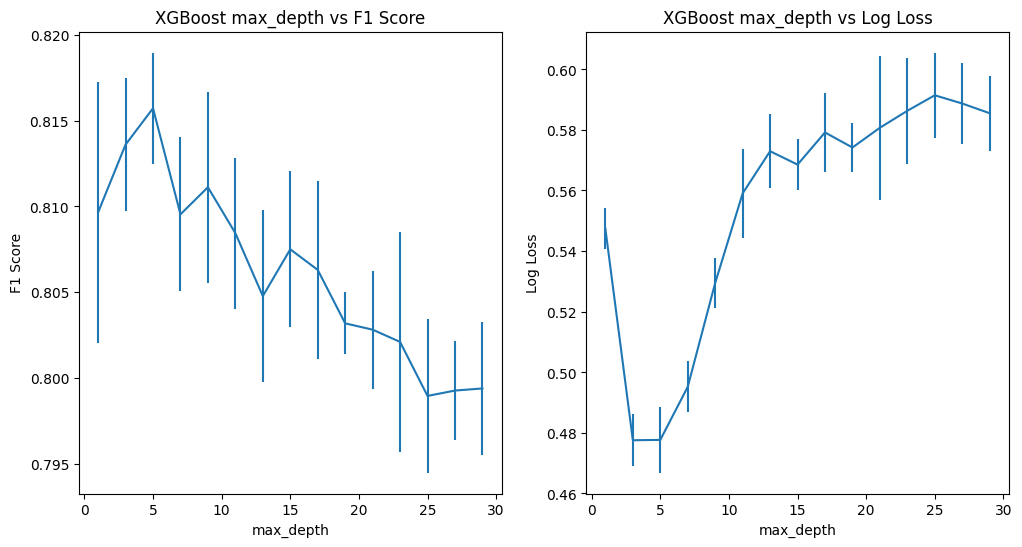

In [ ]:

#'early_stopping_rounds': 20,


import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, f1_score
from matplotlib import pyplot as plt

# Compute sample weights for imbalanced classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

max_depths = range(1, 30, 2)
param_grid = dict(max_depth=max_depths)

xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=200)

xgb_grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=5,
    scoring={'f1_weighted': 'f1_weighted', 'neg_log_loss': 'neg_log_loss'},
    refit='f1_weighted',
    return_train_score=True
)

xgb_grid_search.fit(
    X_train_tfidf, y_train, sample_weight=sample_weights,
    eval_set=[(X_train_tfidf, y_train), (X_train_tfidf, y_train)],
    early_stopping_rounds=20,
    verbose=False
)

print("Best F1 Score: %f using %s" % (xgb_grid_search.best_score_, xgb_grid_search.best_params_))

results = xgb_grid_search.cv_results_
means_f1 = results['mean_test_f1_weighted']
stds_f1 = results['std_test_f1_weighted']
means_log_loss = -results['mean_test_neg_log_loss']
stds_log_loss = results['std_test_neg_log_loss']
params = results['params']

best_log_loss = float('inf')
best_log_loss_params = None

csv_data = []

for mean_f1, std_f1, mean_log_loss, std_log_loss, param in zip(means_f1, stds_f1, means_log_loss, stds_log_loss, params):
    print("max_depth: %d, Mean F1 Score: %f (Std: %f), Mean Log Loss: %f (Std: %f)" %
          (param['max_depth'], mean_f1, std_f1, mean_log_loss, std_log_loss))

    csv_data.append({
        'max_depth': param['max_depth'],
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'mean_log_loss': mean_log_loss,
        'std_log_loss': std_log_loss
    })

    if mean_log_loss < best_log_loss:
        best_log_loss = mean_log_loss
        best_log_loss_params = param

df = pd.DataFrame(csv_data)
df.to_csv('xgboost_max_depth_tuning_results.csv', index=False)

print("Best Log Loss: %f using %s" % (best_log_loss, best_log_loss_params))

# Plot the results for F1 score
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.errorbar(max_depths, means_f1, yerr=stds_f1)
plt.title("XGBoost max_depth vs F1 Score")
plt.xlabel('max_depth')
plt.ylabel('F1 Score')

# Plot the results for Log Loss
plt.subplot(1, 2, 2)
plt.errorbar(max_depths, means_log_loss, yerr=stds_log_loss)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')

plt.savefig('max_depth.png')
plt.show()

[0]	validation_0-mlogloss:1.20583	validation_1-mlogloss:1.21123
[1]	validation_0-mlogloss:1.09369	validation_1-mlogloss:1.10346
[2]	validation_0-mlogloss:1.01405	validation_1-mlogloss:1.02711
[3]	validation_0-mlogloss:0.95402	validation_1-mlogloss:0.97218
[4]	validation_0-mlogloss:0.90759	validation_1-mlogloss:0.92737
[5]	validation_0-mlogloss:0.86908	validation_1-mlogloss:0.89355
[6]	validation_0-mlogloss:0.83547	validation_1-mlogloss:0.86447
[7]	validation_0-mlogloss:0.80899	validation_1-mlogloss:0.84082
[8]	validation_0-mlogloss:0.78440	validation_1-mlogloss:0.82016
[9]	validation_0-mlogloss:0.76330	validation_1-mlogloss:0.80131
[10]	validation_0-mlogloss:0.74259	validation_1-mlogloss:0.78471
[11]	validation_0-mlogloss:0.72536	validation_1-mlogloss:0.76807
[12]	validation_0-mlogloss:0.70867	validation_1-mlogloss:0.75375
[13]	validation_0-mlogloss:0.69467	validation_1-mlogloss:0.74111
[14]	validation_0-mlogloss:0.68063	validation_1-mlogloss:0.73000
[15]	validation_0-mlogloss:0.66822	

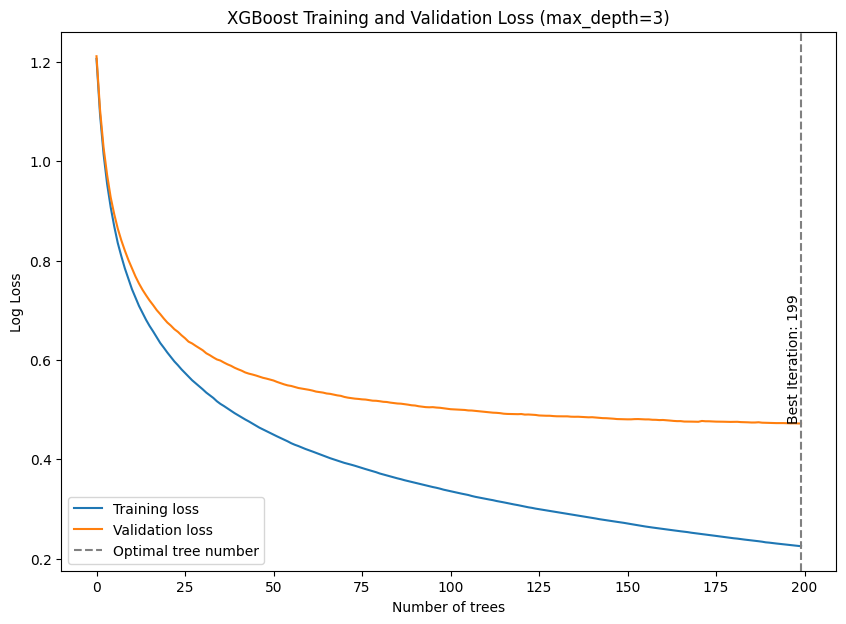

Optimal number of estimators for max_depth 3: 199
[0]	validation_0-mlogloss:1.18250	validation_1-mlogloss:1.18976
[1]	validation_0-mlogloss:1.05092	validation_1-mlogloss:1.06738
[2]	validation_0-mlogloss:0.95922	validation_1-mlogloss:0.98181
[3]	validation_0-mlogloss:0.89157	validation_1-mlogloss:0.92110
[4]	validation_0-mlogloss:0.83840	validation_1-mlogloss:0.87413
[5]	validation_0-mlogloss:0.79826	validation_1-mlogloss:0.83873
[6]	validation_0-mlogloss:0.76310	validation_1-mlogloss:0.80908
[7]	validation_0-mlogloss:0.73575	validation_1-mlogloss:0.78367
[8]	validation_0-mlogloss:0.71131	validation_1-mlogloss:0.76653
[9]	validation_0-mlogloss:0.68644	validation_1-mlogloss:0.74834
[10]	validation_0-mlogloss:0.66729	validation_1-mlogloss:0.73051
[11]	validation_0-mlogloss:0.64925	validation_1-mlogloss:0.71498
[12]	validation_0-mlogloss:0.63383	validation_1-mlogloss:0.70180
[13]	validation_0-mlogloss:0.61700	validation_1-mlogloss:0.69005
[14]	validation_0-mlogloss:0.60416	validation_1-ml

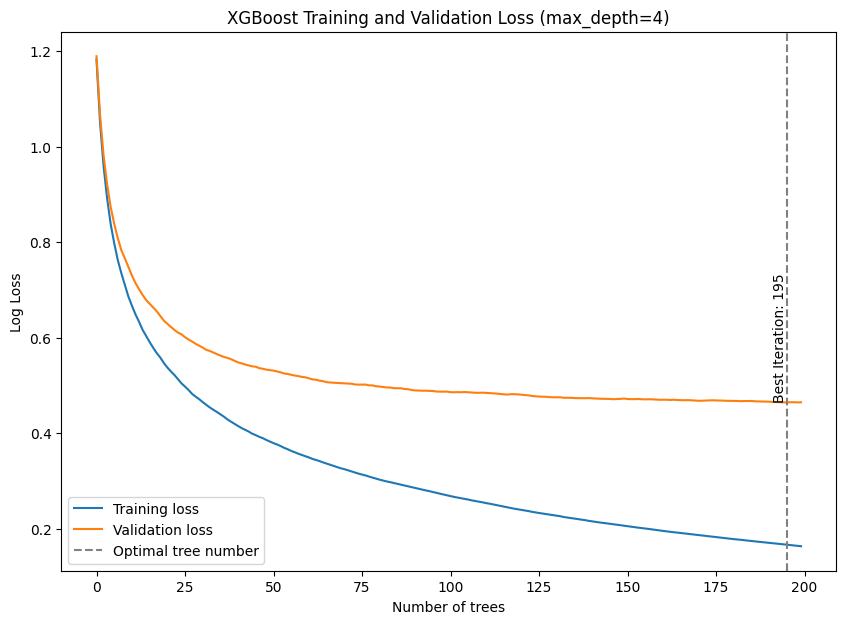

Optimal number of estimators for max_depth 4: 195
[0]	validation_0-mlogloss:1.16484	validation_1-mlogloss:1.17642
[1]	validation_0-mlogloss:1.02019	validation_1-mlogloss:1.04230
[2]	validation_0-mlogloss:0.92006	validation_1-mlogloss:0.95475
[3]	validation_0-mlogloss:0.84567	validation_1-mlogloss:0.89001
[4]	validation_0-mlogloss:0.78701	validation_1-mlogloss:0.83810
[5]	validation_0-mlogloss:0.74280	validation_1-mlogloss:0.80014
[6]	validation_0-mlogloss:0.70642	validation_1-mlogloss:0.77304
[7]	validation_0-mlogloss:0.67626	validation_1-mlogloss:0.74557
[8]	validation_0-mlogloss:0.65096	validation_1-mlogloss:0.72403
[9]	validation_0-mlogloss:0.62919	validation_1-mlogloss:0.70640
[10]	validation_0-mlogloss:0.60917	validation_1-mlogloss:0.68981
[11]	validation_0-mlogloss:0.59120	validation_1-mlogloss:0.67508
[12]	validation_0-mlogloss:0.57543	validation_1-mlogloss:0.66426
[13]	validation_0-mlogloss:0.55790	validation_1-mlogloss:0.65262
[14]	validation_0-mlogloss:0.54552	validation_1-ml

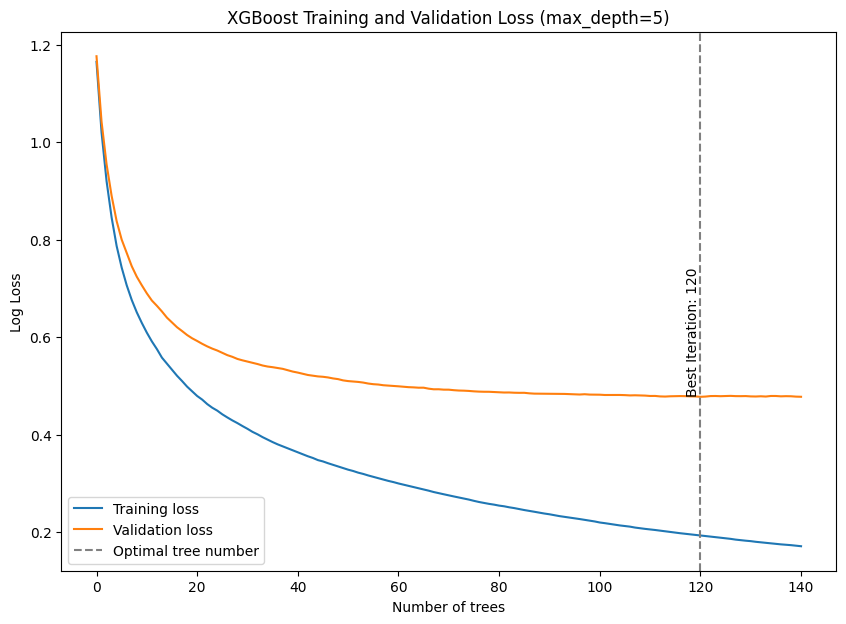

Optimal number of estimators for max_depth 5: 120


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd



X_train, X_validation, y_train, y_validation = train_test_split(X_train_tfidf,
                                                                y_train, test_size=0.2, random_state=42)

depths = range(3, 6, 1)

for max_depth in depths:
    # Compute sample weights for imbalanced classes
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    xgb_classifier = XGBClassifier(
        objective='multi:softprob',
        n_estimators=200,
        max_depth=max_depth,
        learning_rate=0.3,
        early_stopping_rounds=20,
        eval_metric='mlogloss'
    )

    xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_validation, y_validation)],
                       sample_weight=sample_weights, verbose=True)

    results = xgb_classifier.evals_result()

    # Extract log loss values
    train_log_loss = results['validation_0']['mlogloss']
    validation_log_loss = results['validation_1']['mlogloss']

    evaluation_results = pd.DataFrame({
        'train_log_loss': train_log_loss,
        'validation_log_loss': validation_log_loss
    })
    evaluation_results.to_csv(f'xgboost_depth_{max_depth}_evaluation_results.csv', index_label='n_estimators')

    plt.figure(figsize=(10, 7))
    plt.plot(train_log_loss, label="Training loss")
    plt.plot(validation_log_loss, label="Validation loss")
    optimal_estimators = np.argmin(validation_log_loss)
    plt.axvline(x=optimal_estimators, color="gray", linestyle="--", label="Optimal tree number")
    plt.text(optimal_estimators, min(validation_log_loss), f'Best Iteration: {optimal_estimators}', rotation=90, va='bottom', ha='right')
    plt.xlabel("Number of trees")
    plt.ylabel("Log Loss")
    plt.title(f"XGBoost Training and Validation Loss (max_depth={max_depth})")
    plt.legend()
    plt.savefig(f'xgboost_max_depth_{max_depth}.png')
    plt.show()

    print(f"Optimal number of estimators for max_depth {max_depth}: {optimal_estimators}")

In [ ]:
#max depth=4,5 nestimator200 and early stop 20
# 'learning_rate': np.arange(0.01, 1, 0.01),


In [ ]:
import joblib
X_train=joblib.load('/content/drive/My Drive/Master_Thesis/X_train.pkl')
y_train=joblib.load('/content/drive/My Drive/Master_Thesis/y_train.pkl')
X_test=joblib.load('/content/drive/My Drive/Master_Thesis/X_test.pkl')
y_test=joblib.load('/content/drive/My Drive/Master_Thesis/y_test.pkl')

import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import RandomizedSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

X_train_tfidf = best_tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = best_tfidf_vectorizer.transform(X_test)

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, f1_score
from matplotlib import pyplot as plt

# Compute sample weights for imbalanced classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Define parameter grid for XGBoost
param_grid = {
    'max_depth': [4, 5],
    'learning_rate': np.arange(0.00, 0.5, 0.01)
}

xgb_classifier = XGBClassifier(objective='multi:softprob', n_estimators=200)

xgb_grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    cv=5,
    scoring={'f1_weighted': 'f1_weighted', 'neg_log_loss': 'neg_log_loss'},
    refit='f1_weighted',
    return_train_score=True
)

xgb_grid_search.fit(
    X_train_tfidf, y_train, sample_weight=sample_weights,
    eval_set=[(X_train_tfidf, y_train)],
    early_stopping_rounds=20,
    verbose=False
)

print("Best F1 Score: %f using %s" % (xgb_grid_search.best_score_, xgb_grid_search.best_params_))

results = xgb_grid_search.cv_results_
means_f1 = results['mean_test_f1_weighted']
stds_f1 = results['std_test_f1_weighted']
means_log_loss = -results['mean_test_neg_log_loss']
stds_log_loss = results['std_test_neg_log_loss']
params = results['params']

best_log_loss = float('inf')
best_log_loss_params = None

csv_data = []

for mean_f1, std_f1, mean_log_loss, std_log_loss, param in zip(means_f1, stds_f1, means_log_loss, stds_log_loss, params):
    print("Max Depth: %d, Learning Rate: %f, Mean F1 Score: %f (Std: %f), Mean Log Loss: %f (Std: %f)" %
          (param['max_depth'], param['learning_rate'], mean_f1, std_f1, mean_log_loss, std_log_loss))

    csv_data.append({
        'max_depth': param['max_depth'],
        'learning_rate': param['learning_rate'],
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'mean_log_loss': mean_log_loss,
        'std_log_loss': std_log_loss
    })

    # Check if the current log loss is better than the best log loss so far
    if mean_log_loss < best_log_loss:
        best_log_loss = mean_log_loss
        best_log_loss_params = param

df = pd.DataFrame(csv_data)
df.to_csv('/content/drive/My Drive/Master_Thesis/xgboost csv result/xgboost_parameter_tuning_learningrate.csv', index=False)

print("Best Log Loss: %f using %s" % (best_log_loss, best_log_loss_params))

plt.figure(figsize=(12, 6))
for max_depth in [4, 5]:
    max_depth_mask = df['max_depth'] == max_depth
    plt.errorbar(df[max_depth_mask]['learning_rate'], df[max_depth_mask]['mean_f1'], yerr=df[max_depth_mask]['std_f1'], label=f"Max Depth {max_depth}")

plt.title("XGBoost Learning Rate vs F1 Score")
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('/content/drive/My Drive/Master_Thesis/xgboost plot/learning_rate_vs_f1.png')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/pytho

KeyboardInterrupt: 

In [ ]:
#print(best_xgb_params)
#{'reg_lambda': 7.800000000000001, 'reg_alpha': 1.3, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.07054802310718646}


{'reg_lambda': 7.800000000000001, 'reg_alpha': 1.3, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.07054802310718646}


In [ ]:
"""from sklearn.metrics import classification_report

# Train XGBoost classifier using the transformed training data
best_xgb_classifier.fit(X_train_tfidf, y_train)

# Evaluate the best XGBoost classifier on the test set
y_pred = best_xgb_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
 0       0.89      0.98      0.93       780
           1       0.70      0.68      0.69       252
           2       0.72      0.72      0.72       279
           3       0.68      0.47      0.56       236

    accuracy                           0.81      1547
   macro avg       0.75      0.71      0.72      1547
weighted avg       0.80      0.81      0.80      1547
"""

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       780
           1       0.70      0.68      0.69       252
           2       0.72      0.72      0.72       279
           3       0.68      0.47      0.56       236

    accuracy                           0.81      1547
   macro avg       0.75      0.71      0.72      1547
weighted avg       0.80      0.81      0.80      1547



In [ ]:
"""import pandas as pd
import openai

# Load CSV file into DataFrame
df = pd.read_csv('your_data.csv')

# Set up OpenAI API key
openai.api_key = 'your_api_key'

# Group data by labels
grouped_data = df.groupby('labels')

# Initialize list to store augmented samples
augmented_data = []

# Loop through each class
for label, group in grouped_data:
    # Select text data for current class
    text_data = group['text'].tolist()

    # Augment text data for current class
    for original_text in text_data:
        # Define prompt for augmentation
        prompt = "Augment this text: " + original_text + " Generate 5 variations."

        # Generate augmented text using GPT-3.5 TURBO
        response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=prompt,
            max_tokens=50,
            n=5,
            temperature=0.7
        )

        # Extract augmented samples from response and assign labels
        augmented_samples = [{'text': choice['text'].strip(), 'label': label} for choice in response['choices']]

        # Add augmented samples to list
        augmented_data.extend(augmented_samples)

# Convert augmented data to DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Shuffle augmented data
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

# Save augmented data to CSV file
augmented_df.to_csv('augmented_data.csv', index=False)"""

In [ ]:
# Iterate over groups and print each group
"""
df_grouped= df_labeled['generated_summary'].groupby(df_labeled['labels'])


for label, group in df_grouped:
    print(f"Label: {label}")
    print(group)
    print(f"Labelf:{group['generated_summary']}")
    """

In [ ]:
"""
import pandas as pd

# Assuming df_labeled is your DataFrame with 'labels' and 'generated_summary' columns
# Group data by 'labels' based on 'generated_summary' column
df_grouped = df_labeled.groupby('labels')['generated_summary']

# Iterate over groups and print each label and corresponding generated summaries
for label, generated_summary in df_grouped:
    print(f"Label: {label}")
    print(generated_summary)
    """